In [33]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import math
import pandas_market_calendars as mcal
from pandas.tseries.offsets import BDay
from matplotlib import pyplot as plt
from matplotlib import dates
from datetime import datetime, timedelta
from tqdm import tqdm
from pytz import timezone

In [42]:
# Define market timezone
MARKET_TZ = timezone('US/Eastern')

def is_market_open(date):
    """Check if the given date is a trading day in the US market."""
    nyse = mcal.get_calendar('NYSE')
    schedule = nyse.schedule(start_date=date, end_date=date)
    return not schedule.empty

def calculate_vwap(data):
    """
    Calculate intraday VWAP for each day.
    VWAP = cumulative (Typical Price * Volume) / cumulative Volume for the day
    """
    data = data.copy()
    data['Date'] = data.index.date
    data[['High', 'Low', 'Close', 'Volume']] = data[['High', 'Low', 'Close', 'Volume']].apply(pd.to_numeric)
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    data['TPV'] = typical_price * data['Volume']
    data['Cumul_TPV'] = data.groupby('Date')['TPV'].cumsum()
    data['Cumul_Vol'] = data.groupby('Date')['Volume'].cumsum()
    data['VWAP'] = data['Cumul_TPV'] / data['Cumul_Vol']
    return data

def calculate_rsi(data, period=14):
    """Calculate RSI with protection against division by zero."""
    delta = data['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    avg_loss = avg_loss.replace(0, np.finfo(float).eps)
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def apply_strategy(data):
    """Apply the HedgeScalp strategy with improved implementation."""
    if len(data) < 20:
        return pd.DataFrame()
        
    data = calculate_vwap(data)
    data['RSI'] = calculate_rsi(data, period=14)
    data['Vol_MA'] = data['Volume'].rolling(window=20, min_periods=20).mean()
    
    threshold = 0.003
    
    data['ShortSignal'] = (data['Close'] > data['VWAP'] * (1 + threshold)) & \
                          (data['RSI'] > 70) & \
                          (data['Volume'] < data['Vol_MA'] * 0.75)
                          
    data['LongSignal'] = (data['Close'] < data['VWAP'] * (1 - threshold)) & \
                         (data['RSI'] < 30) & \
                         (data['Volume'] < data['Vol_MA'] * 0.75)
    
    data['Signal'] = 0
    data.loc[data['LongSignal'], 'Signal'] = 1
    data.loc[data['ShortSignal'], 'Signal'] = -1
    
    return data

def calculate_regulatory_fees(sell_price, shares):
    """Calculate SEC and FINRA fees for a sell order."""
    # SEC fee: $22.90 per $1,000,000 of principal, rounded up to nearest penny
    principal = sell_price * shares
    sec_fee = (principal / 1e6) * 22.90
    sec_fee = math.ceil(sec_fee * 100) / 100  # Round up to nearest penny

    # FINRA TAF: $0.000119 per share, rounded up to nearest penny, max $5.95
    taf_fee = shares * 0.000119
    taf_fee = math.ceil(taf_fee * 100) / 100
    taf_fee = min(taf_fee, 5.95)

    return sec_fee + taf_fee

def calculate_profit_factor(returns):
    """Calculate profit factor: sum of profits / sum of losses."""
    if len(returns) == 0:
        return 0
    
    profits = returns[returns > 0].sum()
    losses = abs(returns[returns < 0].sum())
    
    if losses == 0:
        return float('inf') if profits > 0 else 0
    
    return profits / losses

In [35]:
def get_historical_data(ticker, start_date, end_date):
    """
    Retrieve historical data from local storage or download new data and append.
    Returns timezone-aware DataFrame in MARKET_TZ.
    """
    os.makedirs('historical_data', exist_ok=True)
    file_path = f'historical_data/{ticker}.csv'
    
    # Convert input dates to timezone-aware datetime objects
    start_date = pd.to_datetime(start_date).tz_localize(MARKET_TZ)
    end_date = pd.to_datetime(end_date).tz_localize(MARKET_TZ)
    
    try:
        # Load existing data if available
        if os.path.exists(file_path):
            existing_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
            existing_data.index = existing_data.index.tz_localize(MARKET_TZ)
            last_date = existing_data.index.max()
        else:
            existing_data = pd.DataFrame()
            last_date = None
        
        # Determine date range needed
        download_start = last_date + timedelta(minutes=1) if last_date else start_date
        download_end = end_date
        
        # Only download if needed
        if not last_date or download_start < download_end:
            # Download new data
            new_data = yf.download(ticker, 
                                 start=download_start.tz_localize(None), 
                                 end=download_end.tz_localize(None),
                                 interval='1m')
            
            if not new_data.empty:
                # If data has multiple column levels, reduce to a single level.
                if isinstance(new_data.columns, pd.MultiIndex):
                    new_data.columns = new_data.columns.get_level_values(0)
                    
                # Convert index to market timezone
                new_data.index = new_data.index.tz_convert(MARKET_TZ)
                
                # Combine with existing data
                combined_data = pd.concat([existing_data, new_data])
                # Remove duplicates keeping last entry
                combined_data = combined_data[~combined_data.index.duplicated(keep='last')]
                combined_data.sort_index(inplace=True)
                
                # Save with naive timestamp
                combined_data_naive = combined_data.copy()
                combined_data_naive.index = combined_data_naive.index.tz_localize(None)
                combined_data_naive.to_csv(file_path)
            else:
                combined_data = existing_data
        else:
            combined_data = existing_data
        
        # Filter for requested date range
        filtered_data = combined_data.loc[start_date:end_date]
        return filtered_data
    
    except Exception as e:
        print(f"Error loading data for {ticker}: {e}")
        return pd.DataFrame()

In [ ]:
def run_backtest(tickers, start_date, end_date, use_trailing_stop=True, exit_bars=60):
    """
    Run a backtest of the HedgeScalp strategy on multiple stocks
    
    Parameters:
    - tickers: List of stock symbols
    - start_date: Starting date for backtest
    - end_date: Ending date for backtest
    - use_trailing_stop: Whether to use trailing stops
    - exit_bars: Number of bars (minutes) before time-based exit
    
    Returns:
    - DataFrame of all trades and performance metrics
    """
    all_trades = []
    trade_logs = {}
    
    pbar = tqdm(tickers, desc="Processing Stocks")
    for ticker in pbar:
        pbar.set_description(f"Processing {ticker}")
        try:
            data = get_historical_data(ticker, start_date, end_date)
            if data.empty:
                continue
            
            # Apply HedgeScalp strategy to generate signals.
            data = apply_strategy(data)
            
            # Skip if no signals were generated.
            if 'Signal' not in data.columns or data['Signal'].abs().sum() == 0:
                continue
            
            # Initialize tracking for this ticker
            active_trades = {}
            ticker_trades = []
            
            # Process day by day
            for day, day_data in data.groupby(data.index.date):
                # Track VWAP components for this day
                cumul_tpv = 0
                cumul_vol = 0
                
                # Process each bar (minute) during the day
                for t, row in day_data.iterrows():
                    # Update VWAP for this bar
                    tp = (row['High'] + row['Low'] + row['Close']) / 3
                    cumul_tpv += tp * row['Volume']
                    cumul_vol += row['Volume']
                    
                    vwap = cumul_tpv / cumul_vol if cumul_vol > 0 else row['Close']
                    
                    # Check trailing stops for active trades
                    trades_to_close = []
                    for entry_time, trade in active_trades.items():
                        if use_trailing_stop:
                            # For long positions, trailing stop is previous candle's close
                            if trade['Direction'] == 'Long':
                                prev_idx = day_data.index.get_loc(t) - 1
                                if prev_idx > 0:
                                    new_stop = day_data['Close'].iloc[prev_idx]
                                    if trade['Stop'] is None or new_stop > trade['Stop']:
                                        active_trades[entry_time]['Stop'] = new_stop
                                        
                                    # Check if current price hits trailing stop
                                    if row['Low'] <= trade['Stop']:
                                        trade['Exit Price'] = trade['Stop']
                                        trade['Exit Time'] = t
                                        trade['Exit Reason'] = 'Trailing Stop'
                                        
                                        # Calculate return
                                        ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                                        trade['Return'] = ret
                                        trade['Return %'] = ret * 100
                                        
                                        ticker_trades.append(trade)
                                        trades_to_close.append(entry_time)
                            
                            # For short positions, trailing stop is previous candle's open
                            elif trade['Direction'] == 'Short':
                                prev_idx = day_data.index.get_loc(t) - 1
                                if prev_idx > 0:
                                    new_stop = day_data['Open'].iloc[prev_idx]
                                    if trade['Stop'] is None or new_stop < trade['Stop']:
                                        active_trades[entry_time]['Stop'] = new_stop
                                        
                                    # Check if current price hits trailing stop
                                    if row['High'] >= trade['Stop']:
                                        trade['Exit Price'] = trade['Stop']
                                        trade['Exit Time'] = t
                                        trade['Exit Reason'] = 'Trailing Stop'
                                        
                                        # Calculate return
                                        ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                                        trade['Return'] = ret
                                        trade['Return %'] = ret * 100
                                        
                                        ticker_trades.append(trade)
                                        trades_to_close.append(entry_time)
                        
                        # Time-based exit (after exit_bars minutes)
                        time_passed = (t - entry_time).total_seconds() / 60
                        if time_passed >= exit_bars:
                            trade['Exit Price'] = row['Close']
                            trade['Exit Time'] = t
                            trade['Exit Reason'] = 'Time-based'
                            
                            if trade['Direction'] == 'Long':
                                ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                            else:
                                ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                                
                            trade['Return'] = ret
                            trade['Return %'] = ret * 100
                            
                            ticker_trades.append(trade)
                            trades_to_close.append(entry_time)
                    
                    # Remove closed trades
                    for entry_time in trades_to_close:
                        del active_trades[entry_time]
                    
                    # Process new entry signals when not in a position
                    if t not in active_trades and row['Signal'] != 0:
                        direction = 'Long' if row['Signal'] == 1 else 'Short'
                        
                        # Set initial trailing stop
                        initial_stop = None
                        prev_idx = day_data.index.get_loc(t) - 1 if t in day_data.index else -1
                        if prev_idx > 0:
                            if direction == 'Long':
                                initial_stop = day_data['Close'].iloc[prev_idx]
                            else:
                                initial_stop = day_data['Open'].iloc[prev_idx]
                        
                        active_trades[t] = {
                            'Symbol': ticker,
                            'DateTime': t,
                            'Direction': direction,
                            'Entry Price': row['Close'],
                            'Stop': initial_stop,
                            'RSI': row['RSI'],
                            'VWAP': vwap,
                            'Volume': row['Volume'],
                            'Vol_MA': row['Vol_MA']
                        }
                        
                        # print(f"{direction} {ticker} at {row['Close']:.2f} on {t} (RSI: {row['RSI']:.2f}, VWAP: {vwap:.2f})")
            
            # Close any remaining open trades at the end of data
            for entry_time, trade in active_trades.items():
                last_row = data.iloc[-1]
                trade['Exit Price'] = last_row['Close'] 
                trade['Exit Time'] = data.index[-1]
                trade['Exit Reason'] = 'End of Data'
                
                if trade['Direction'] == 'Long':
                    ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                else:
                    ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                    
                trade['Return'] = ret
                trade['Return %'] = ret * 100
                
                ticker_trades.append(trade)
            
            # Add ticker trades to overall results
            all_trades.extend(ticker_trades)
            
            # Store in trade logs for performance summary
            if ticker_trades:
                trade_logs[ticker] = [t['Return'] for t in ticker_trades]
                
                # Print performance for this ticker
                total_pnl = sum(trade_logs[ticker])
                num_trades = len(trade_logs[ticker])
                # print(f"{ticker}: Total PnL: {total_pnl:.4f} from {num_trades} trades")
                
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue
    
    # Create results dataframe 
    if all_trades:
        results = pd.DataFrame(all_trades)
        results.sort_values('DateTime', inplace=True)
        
        # Print overall performance summary
        print("\n=== Overall Performance Summary ===")
        print(f"Total Return: {results['Return'].sum():.4f} ({results['Return %'].sum():.2f}%)")
        print(f"Average Return per Trade: {results['Return'].mean():.4f} ({results['Return %'].mean():.2f}%)")
        print(f"Win Rate: {(results['Return'] > 0).mean():.2%}")
        print(f"Total Number of Trades: {len(results)}")
        
        # Print per-stock summary
        print("\n=== Per-stock Trade Performance Summary ===")
        for symbol, pnl_list in trade_logs.items():
            total_pnl = sum(pnl_list)
            num_trades = len(pnl_list)
            win_rate = sum(1 for pnl in pnl_list if pnl > 0) / num_trades if num_trades > 0 else 0
            print(f"{symbol}: Total PnL: {total_pnl:.4f} from {num_trades} trades (Win rate: {win_rate:.2%})")
        
        return results
    else:
        print("No trades were generated.")
        return pd.DataFrame()

In [38]:
tickers = [
    "MSTR", "COIN", "RIVN", "CVNA", "PLTR", "DJT", "AMD", "MRNA", "DKNG", "SNAP",
    "MARA", "RIOT", "KMX", "CLSK", "CORZ", "HUT", "CZR", "NVDA", "AVGO",
]

# Run the backtest
today = datetime.now().date()
if not is_market_open(today):
    print(f"Market is closed ({today}). Adjusting to last trading day.")
    end_date = (datetime.now() - BDay(1))
    start_date = (end_date - timedelta(days=7))

results = run_backtest(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    use_trailing_stop=True,
    exit_bars=5
)

Market is closed (2025-04-18). Adjusting to last trading day.


Processing PLTR:  21%|██        | 4/19 [00:00<00:03,  4.86it/s]

Error processing CVNA: Timestamp('2025-04-17 13:56:00-0400', tz='US/Eastern')


Processing AVGO: 100%|██████████| 19/19 [00:03<00:00,  6.13it/s]


=== Overall Performance Summary ===
Total Return: 1.5075 (150.75%)
Average Return per Trade: 0.0013 (0.13%)
Win Rate: 71.18%
Total Number of Trades: 1204

=== Per-stock Trade Performance Summary ===
MSTR: Total PnL: 0.0494 from 44 trades (Win rate: 72.73%)
COIN: Total PnL: 0.0575 from 51 trades (Win rate: 78.43%)
RIVN: Total PnL: 0.0847 from 87 trades (Win rate: 68.97%)
PLTR: Total PnL: 0.0410 from 29 trades (Win rate: 75.86%)
DJT: Total PnL: 0.1194 from 93 trades (Win rate: 65.59%)
AMD: Total PnL: 0.0278 from 42 trades (Win rate: 69.05%)
MRNA: Total PnL: 0.0487 from 57 trades (Win rate: 61.40%)
DKNG: Total PnL: 0.1092 from 79 trades (Win rate: 77.22%)
SNAP: Total PnL: 0.0737 from 69 trades (Win rate: 63.77%)
MARA: Total PnL: 0.0683 from 63 trades (Win rate: 68.25%)
RIOT: Total PnL: 0.0975 from 81 trades (Win rate: 64.20%)
KMX: Total PnL: 0.0679 from 55 trades (Win rate: 85.45%)
CLSK: Total PnL: 0.1206 from 78 trades (Win rate: 65.38%)
CORZ: Total PnL: 0.1883 from 120 trades (Win rate


Performance Validity Analysis


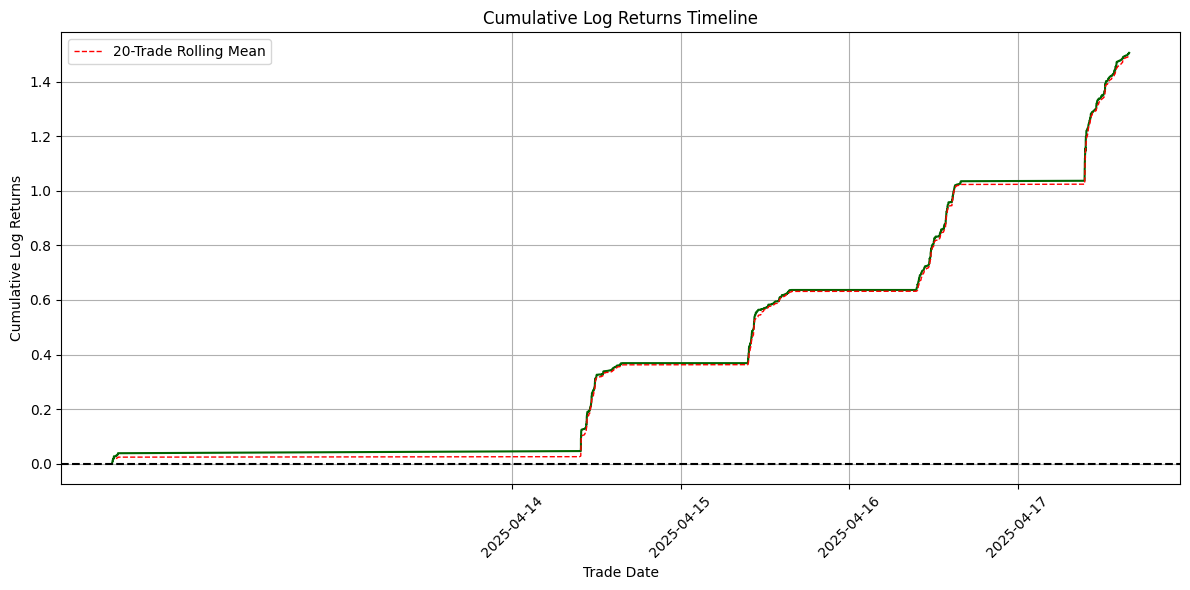

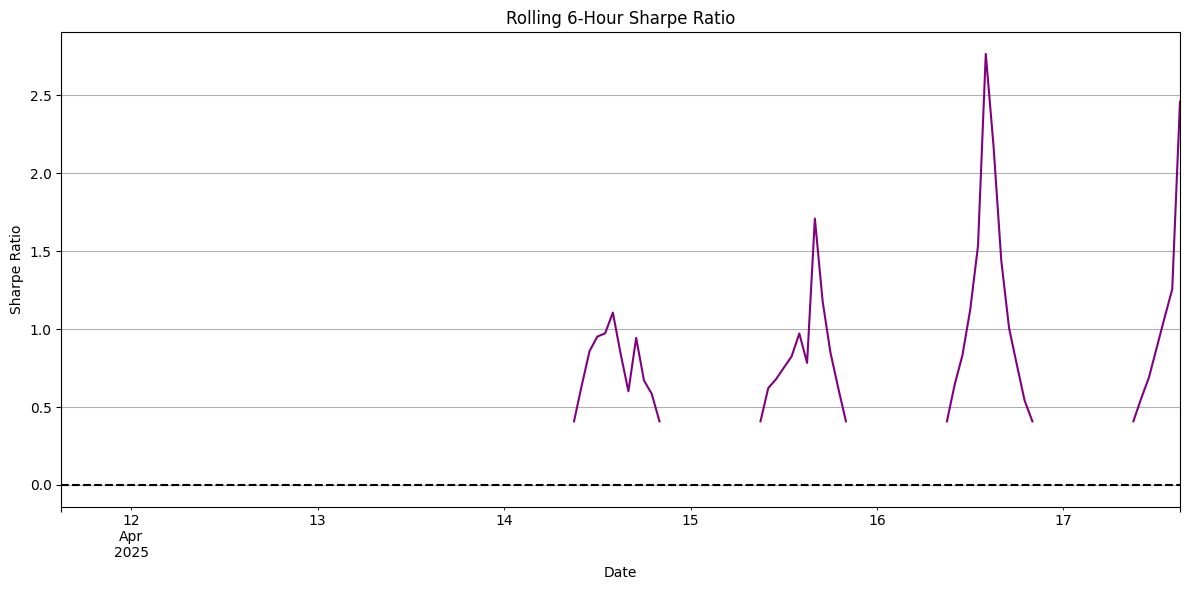

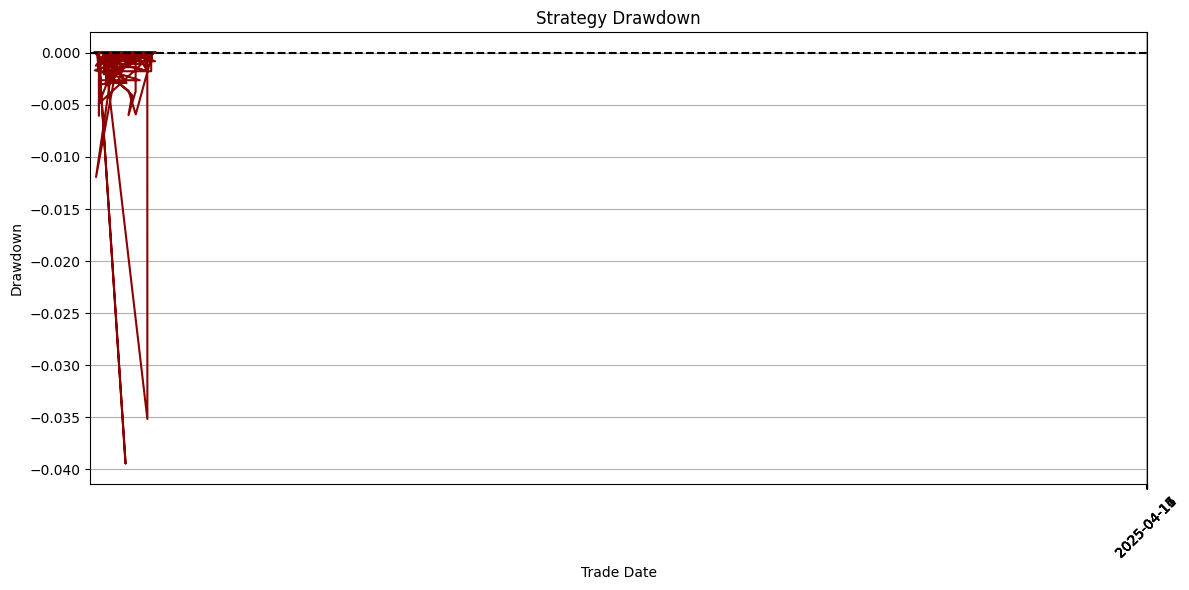

In [39]:
if not results.empty:
    # -------------------------------
    # Performance Validity Checks
    # -------------------------------
    print("\n" + "="*40 + "\nPerformance Validity Analysis\n" + "="*40)
    
    # Convert to datetime if needed
    results['Exit Time'] = pd.to_datetime(results['Exit Time'])
    
    # 1. Cumulative Log Returns Timeline
    plt.figure(figsize=(12, 6))
    results.sort_values('Exit Time', inplace=True)
    cumulative_log_returns = np.log1p(results['Return']).cumsum()
    
    # Get unique dates with trades
    unique_dates = results['Exit Time'].dt.normalize().unique()
    
    plt.plot(results['Exit Time'], cumulative_log_returns, 
            color='darkgreen', linewidth=1.5)
    plt.title('Cumulative Log Returns Timeline')
    plt.xlabel('Trade Date')
    plt.ylabel('Cumulative Log Returns')
    plt.grid(True)
    plt.axhline(0, color='black', linestyle='--')
    
    # Set x-axis ticks to actual trade dates
    plt.xticks(unique_dates, rotation=45)
    plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))
    
    # Add rolling mean
    rolling_mean = cumulative_log_returns.rolling(20).mean()
    plt.plot(results['Exit Time'], rolling_mean, 
            color='red', linestyle='--', linewidth=1,
            label='20-Trade Rolling Mean')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Rolling Sharpe Ratio (6-hour window)
    results['Returns'] = results['Return']
    hourly_returns = results.set_index('Exit Time')['Returns'].resample('1h').sum()
    
    # Filter to only hours with trades
    hourly_returns = hourly_returns[hourly_returns.notna()]
    
    rolling_window = 6
    rolling_sharpe = hourly_returns.rolling(rolling_window).mean() / hourly_returns.rolling(rolling_window).std()
    
    plt.figure(figsize=(12, 6))
    rolling_sharpe.plot(color='purple', linewidth=1.5)
    plt.title(f'Rolling {rolling_window}-Hour Sharpe Ratio')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.axhline(0, color='black', linestyle='--')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 3. Drawdown Analysis
    cumulative_returns = np.exp(cumulative_log_returns) - 1
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak)/peak
    
    plt.figure(figsize=(12, 6))
    drawdown.plot(color='darkred', linewidth=1.5)
    plt.title('Strategy Drawdown')
    plt.xlabel('Trade Date')
    plt.ylabel('Drawdown')
    plt.axhline(0, color='black', linestyle='--')
    plt.grid(True)
    plt.xticks(unique_dates, rotation=45)
    plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))
    plt.tight_layout()
    plt.show()

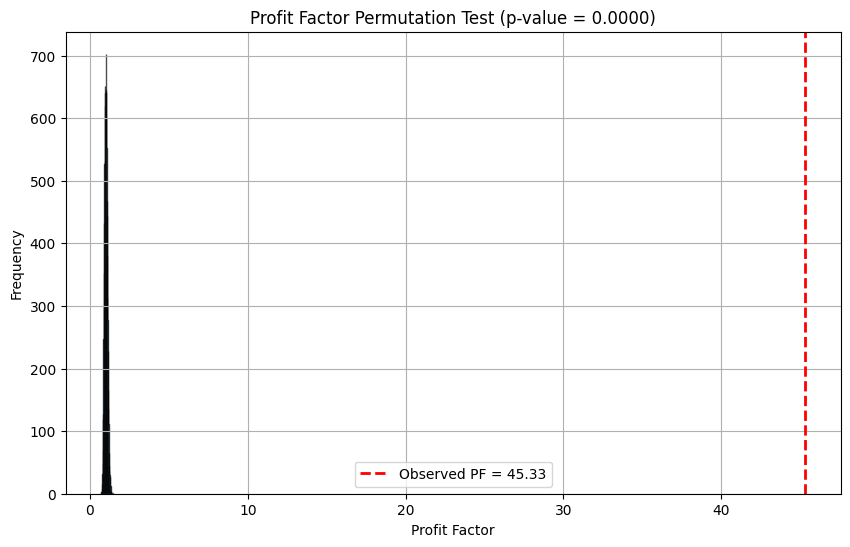


=== Profit Factor Permutation Test ===
Observed Profit Factor: 45.3260
Mean Permutation Profit Factor: 1.0046
P-value: 0.0000
Result: The observed profit factor is statistically significant (p < 0.05)

Profit Factor Permutation Test p-value: 0.0000
Result: Statistically significant profit factor (p < 0.05)


In [40]:
# Extract returns array
returns_array = results['Return'].values

# Run permutation test (e.g., 10,000 permutations)
p_value = perform_profit_factor_permutation_test(returns_array, n_permutations=10000)

# Display p-value
print(f"\nProfit Factor Permutation Test p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: Statistically significant profit factor (p < 0.05)")
else:
    print("Result: Profit factor not statistically significant (p >= 0.05)")


Return Distribution

--- Return Statistics ---
|        |     count |   mean |    std |     min |    10% |    25% |    50% |    75% |    90% |    99% |   99.9% |   99.99% |    max |
|:-------|----------:|-------:|-------:|--------:|-------:|-------:|-------:|-------:|-------:|-------:|--------:|---------:|-------:|
| Return | 1204.0000 | 0.0013 | 0.0016 | -0.0041 | 0.0000 | 0.0000 | 0.0008 | 0.0019 | 0.0033 | 0.0068 |  0.0106 |   0.0134 | 0.0137 |

--- Worst Outcomes ---
|        |   Worst 5.00% |   Worst 1.00% |   Worst 0.10% |   Worst 0.01% |
|:-------|--------------:|--------------:|--------------:|--------------:|
| Return |        0.0000 |       -0.0012 |       -0.0025 |       -0.0039 |


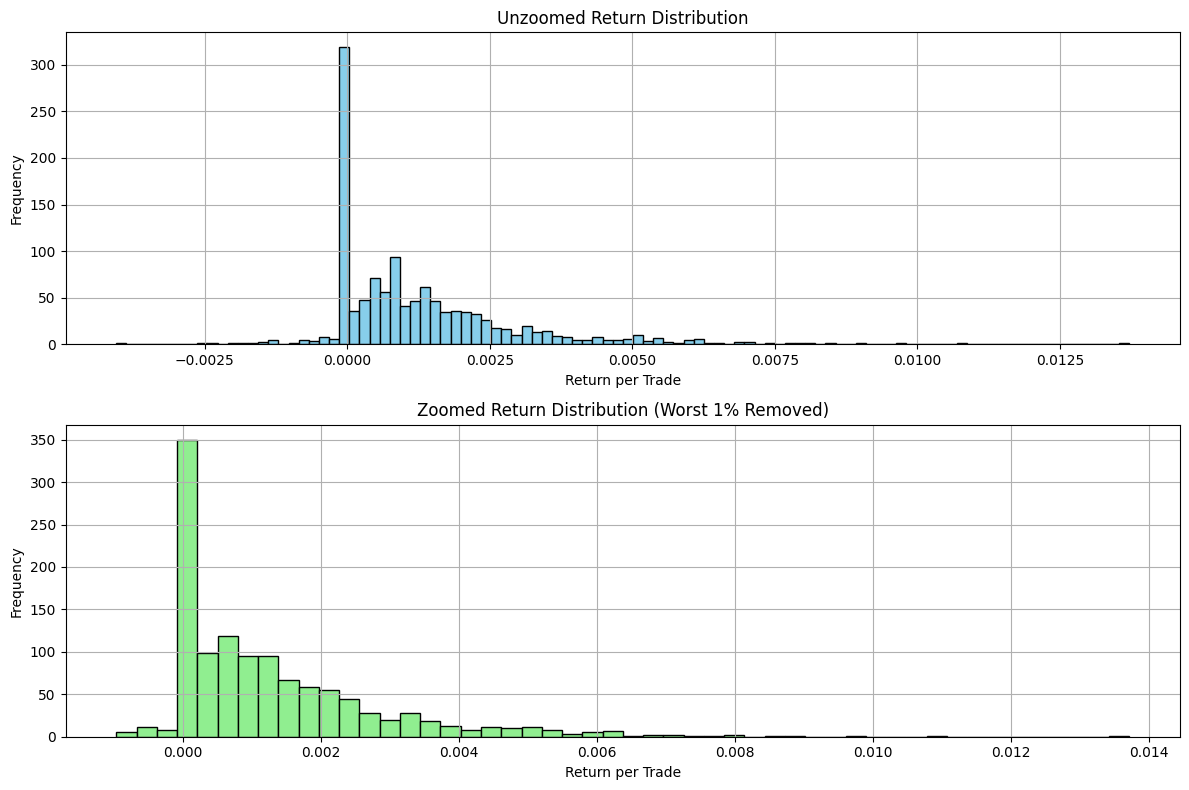

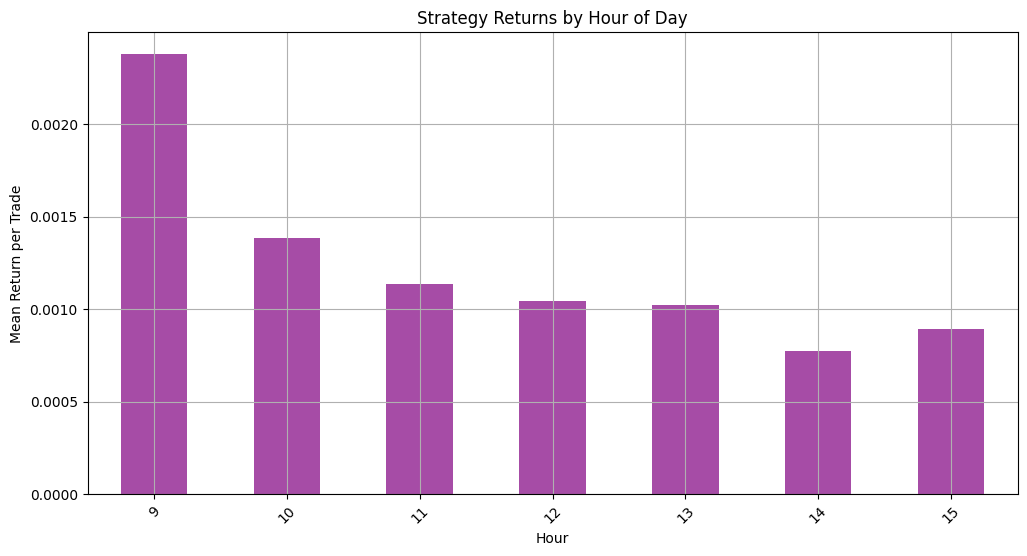

C:\Users\Administrator\AppData\Local\Temp\ipykernel_43876\853235495.py:51: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  results['Day'] = results['DateTime'].dt.to_period('D')


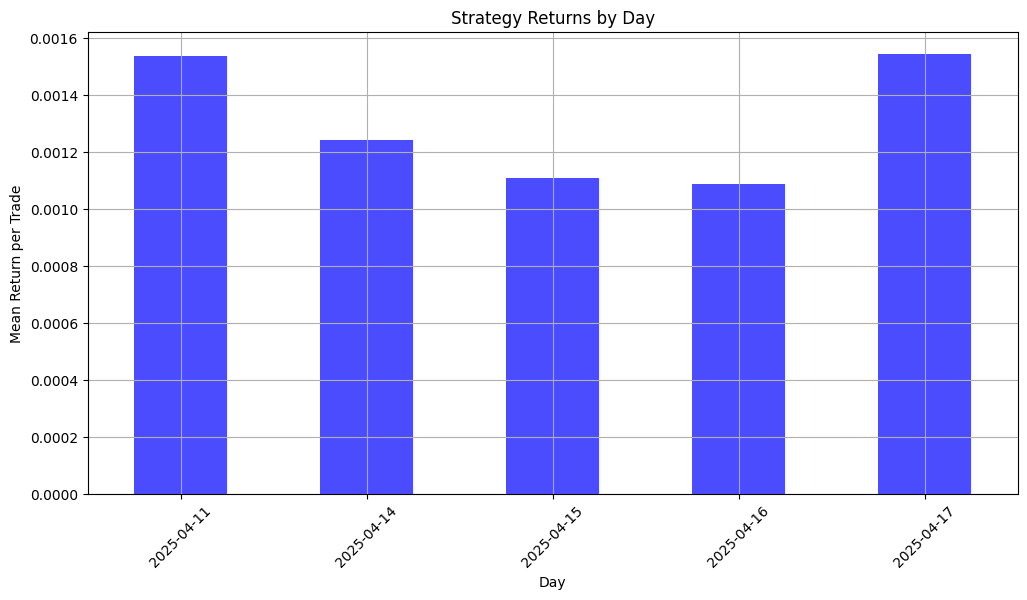


Kelly Criterion

--- 1 Day Simulations ---

Kelly Fraction: 100% for 1 Day window
|    | Kelly %   |    count |    mean |   std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 100%      | 10000.00 | 1602.22 | 53.59 | 1428.08 | 1487.97 | 1535.21 | 1564.78 | 1600.46 | 1637.32 | 1671.63 | 1735.67 | 1845.82 |


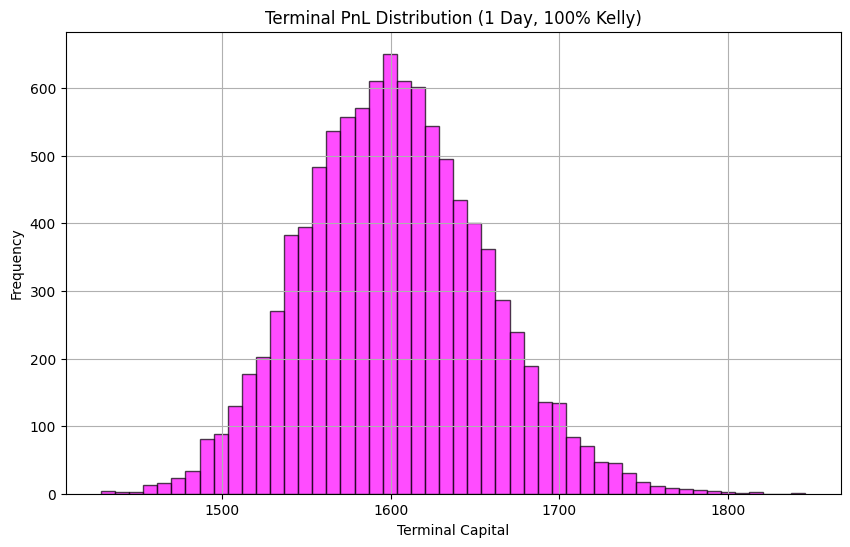

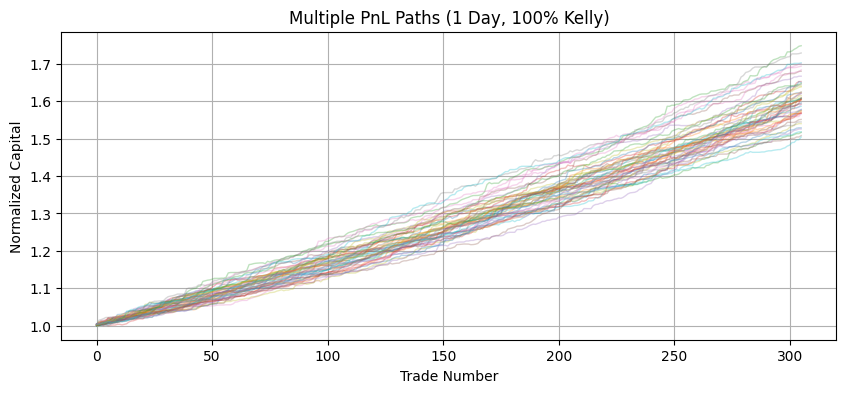


Kelly Fraction: 50% for 1 Day window
|    | Kelly %   |    count |    mean |   std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 50%       | 10000.00 | 1265.90 | 21.18 | 1195.19 | 1220.03 | 1239.27 | 1251.16 | 1265.37 | 1279.90 | 1293.27 | 1317.87 | 1359.08 |


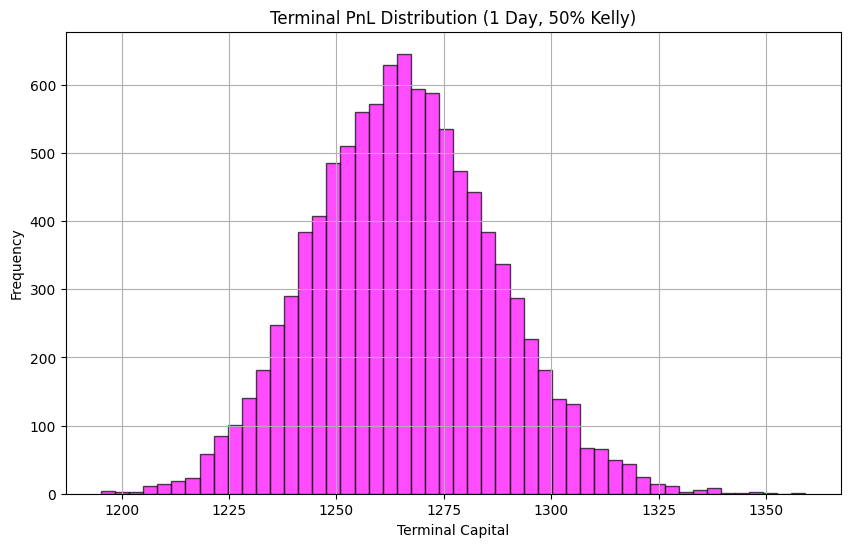

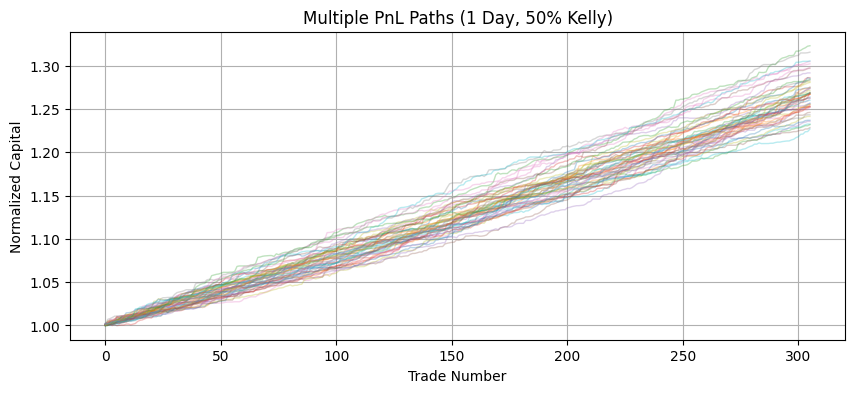


Kelly Fraction: 30% for 1 Day window
|    | Kelly %   |    count |    mean |   std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 30%       | 10000.00 | 1151.99 | 11.57 | 1112.96 | 1126.79 | 1137.42 | 1143.96 | 1151.74 | 1159.66 | 1166.91 | 1180.20 | 1202.22 |


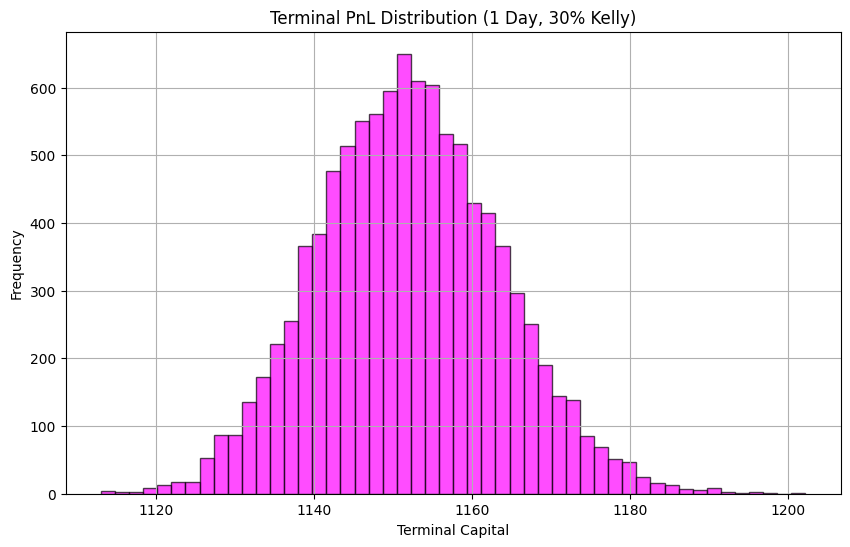

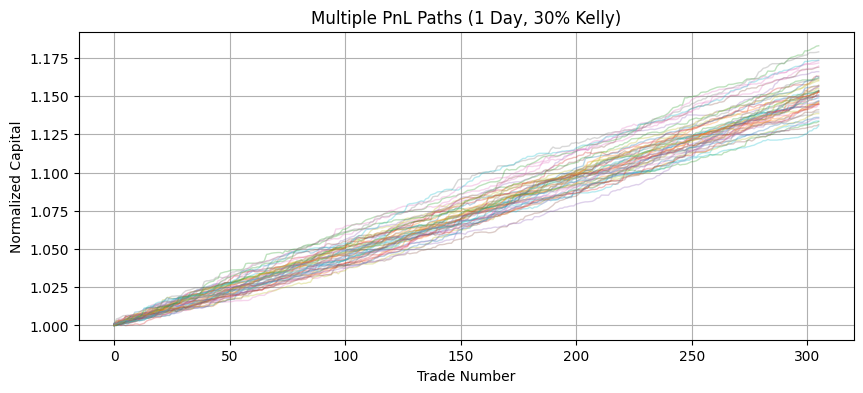


--- 3 Days Simulations ---

Kelly Fraction: 100% for 3 Days window
|    | Kelly %   |    count |    mean |    std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|-------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 100%      | 10000.00 | 3118.60 | 149.95 | 2591.04 | 2788.04 | 2930.82 | 3016.44 | 3112.38 | 3214.56 | 3311.01 | 3503.25 | 3760.13 |


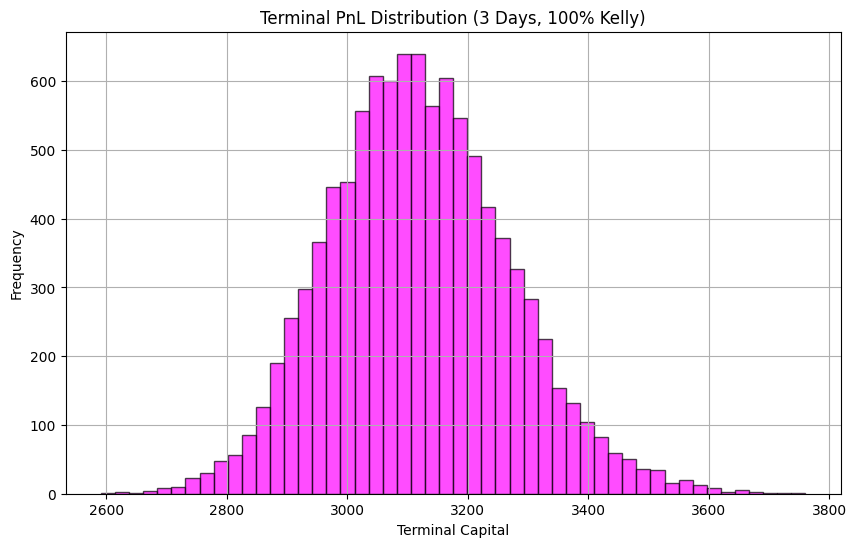

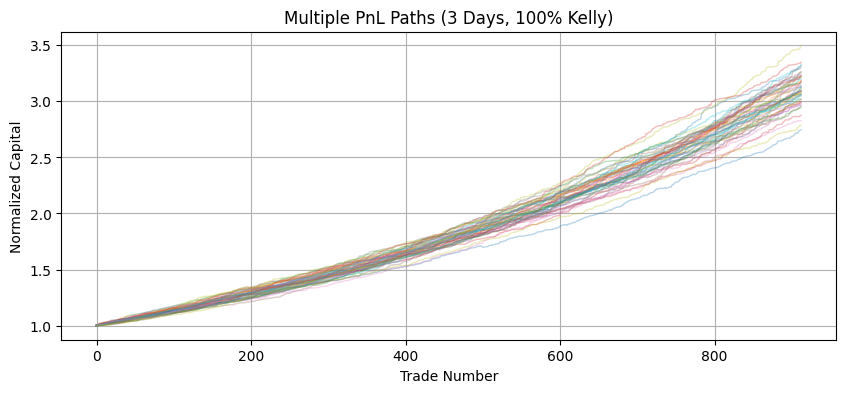


Kelly Fraction: 50% for 3 Days window
|    | Kelly %   |    count |    mean |   std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 50%       | 10000.00 | 1766.28 | 42.45 | 1610.25 | 1670.39 | 1712.71 | 1737.57 | 1765.02 | 1793.80 | 1820.57 | 1872.83 | 1940.35 |


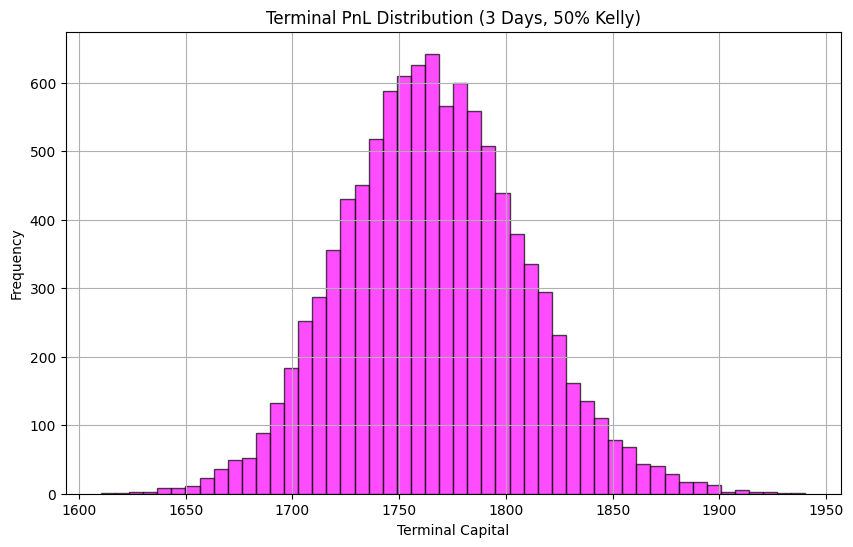

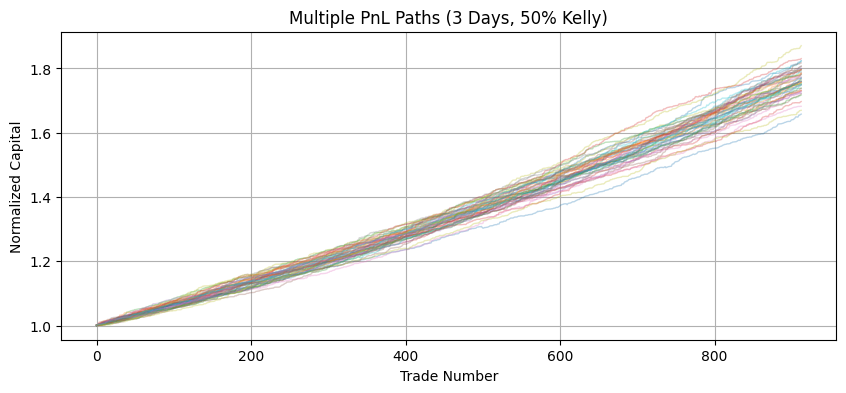


Kelly Fraction: 30% for 3 Days window
|    | Kelly %   |    count |    mean |   std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 30%       | 10000.00 | 1406.87 | 20.29 | 1330.98 | 1360.60 | 1381.20 | 1393.20 | 1406.36 | 1420.09 | 1432.78 | 1457.35 | 1488.66 |


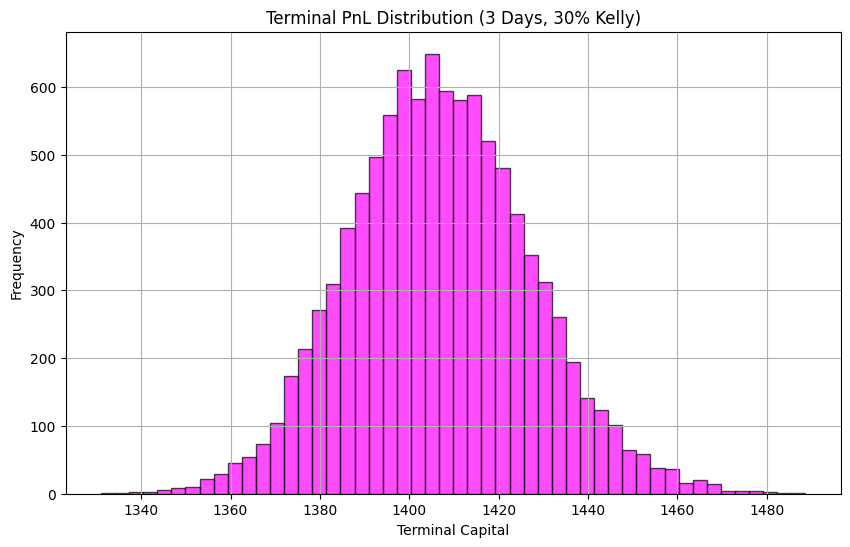

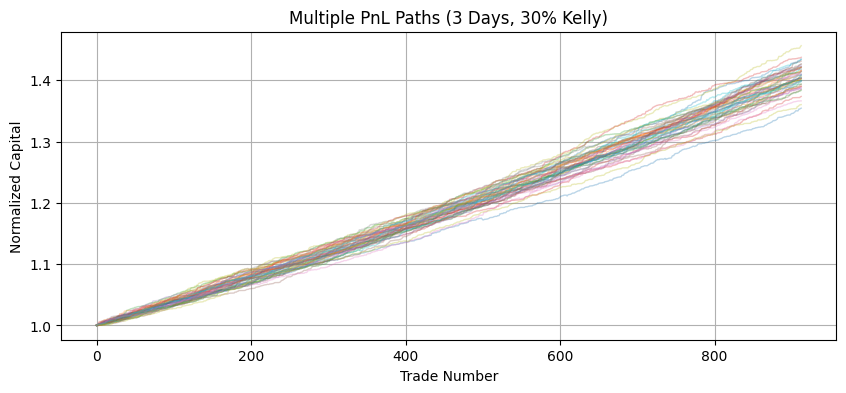


--- Full Dataset Simulations ---

Kelly Fraction: 100% for Full Dataset window
|    | Kelly %   |    count |    mean |    std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|-------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 100%      | 10000.00 | 4512.88 | 251.13 | 3680.99 | 3968.33 | 4199.93 | 4340.19 | 4504.58 | 4674.64 | 4838.33 | 5145.27 | 5624.29 |


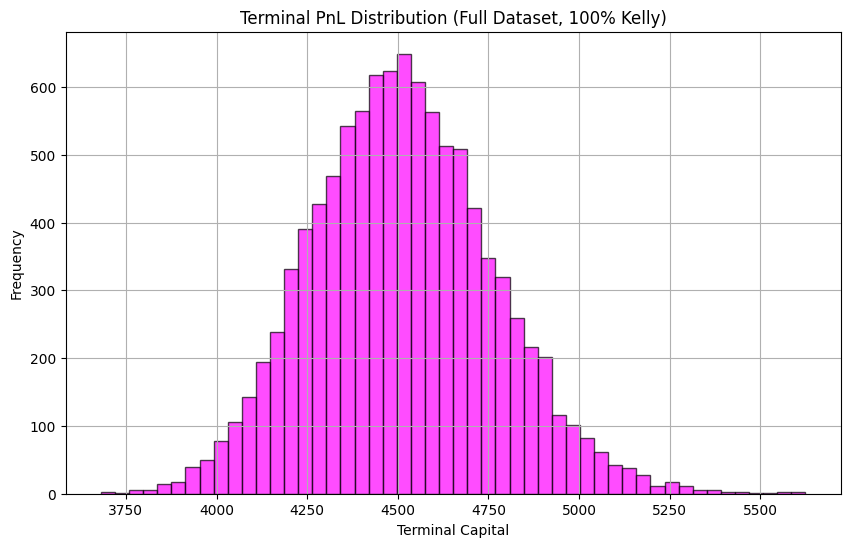

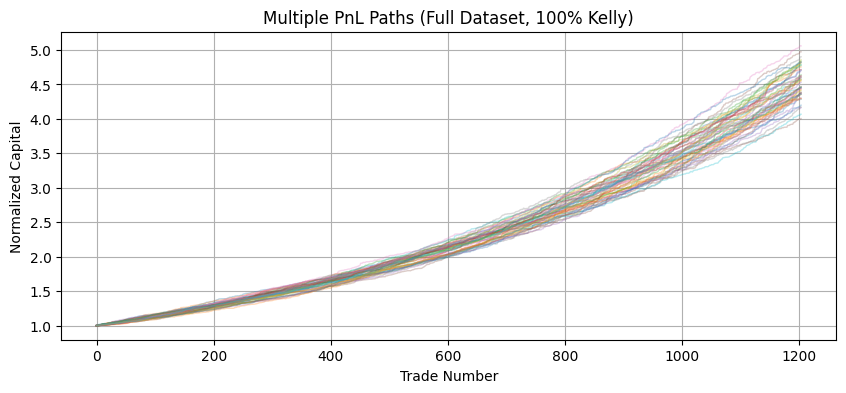


Kelly Fraction: 50% for Full Dataset window
|    | Kelly %   |    count |    mean |   std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 50%       | 10000.00 | 2124.86 | 59.11 | 1919.54 | 1993.13 | 2050.57 | 2084.55 | 2123.71 | 2163.51 | 2201.08 | 2269.96 | 2373.51 |


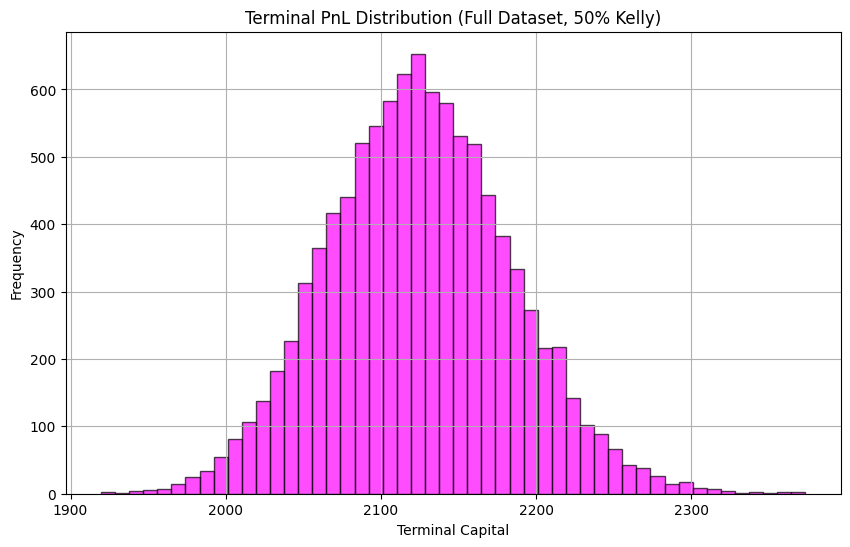

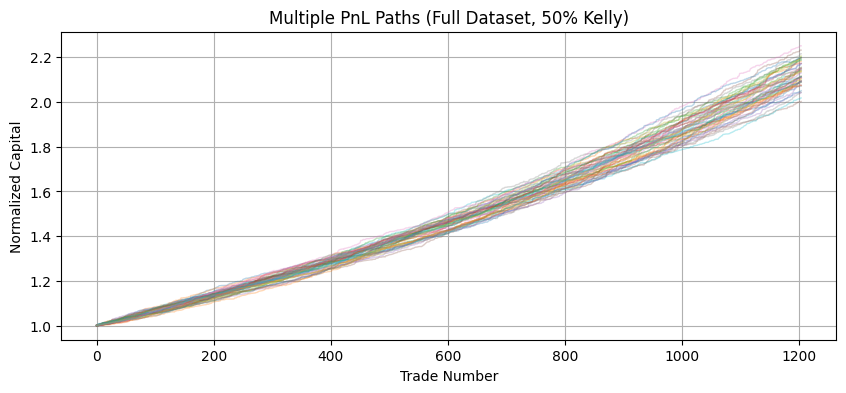


Kelly Fraction: 30% for Full Dataset window
|    | Kelly %   |    count |    mean |   std |     min |      1% |     10% |     25% |     50% |     75% |     90% |     99% |     max |
|---:|:----------|---------:|--------:|------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
|  0 | 30%       | 10000.00 | 1571.89 | 26.24 | 1479.00 | 1512.78 | 1538.81 | 1554.09 | 1571.54 | 1589.15 | 1605.65 | 1635.63 | 1680.05 |


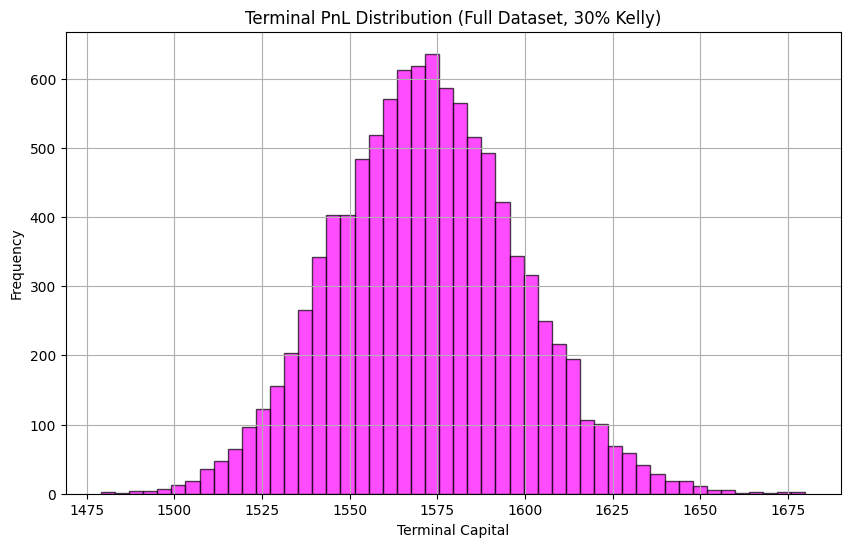

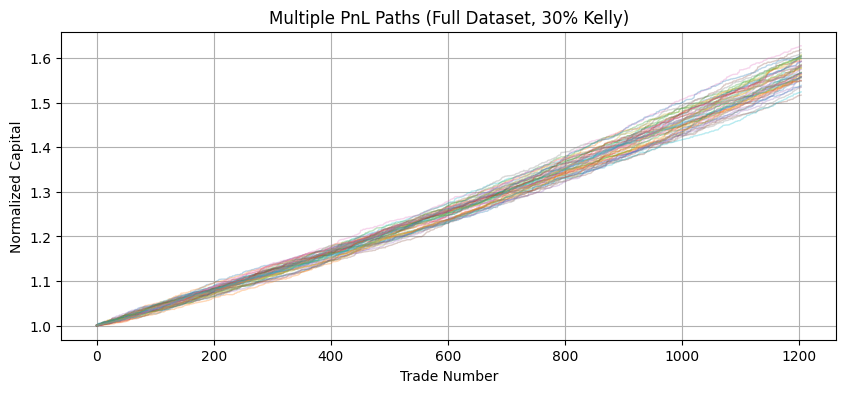


Trade Entry/Exit Analysis


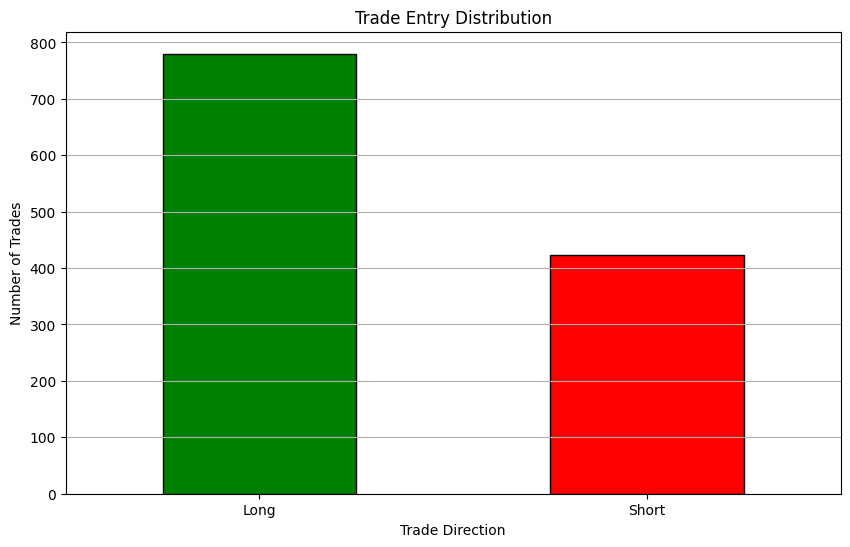

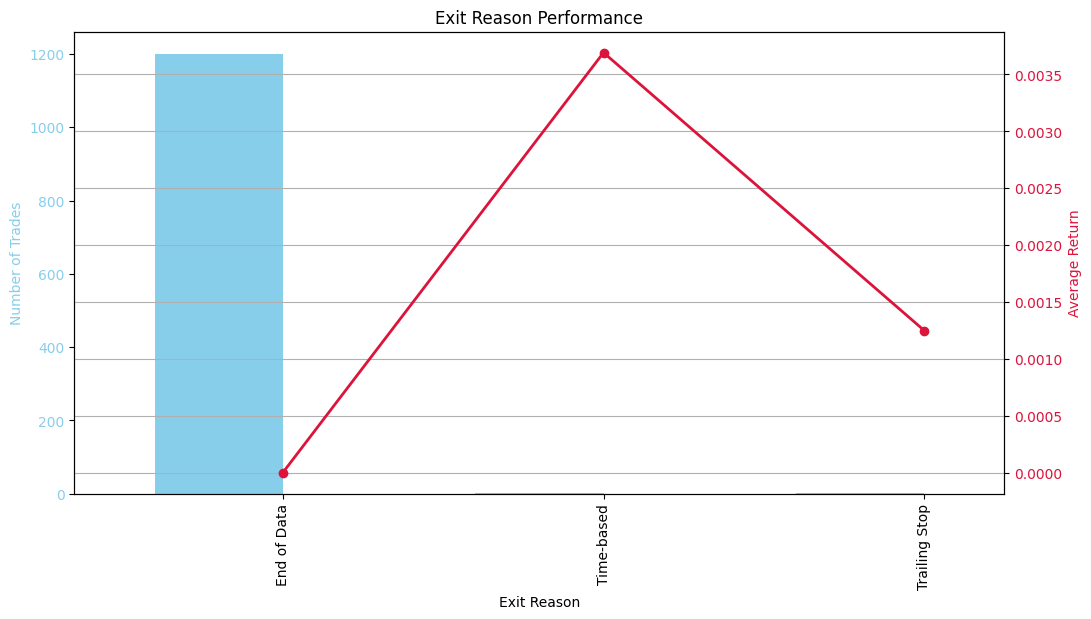


--- Trade Direction Summary ---
|       |   Long |   Short |
|:------|-------:|--------:|
| count |    780 |     424 |

--- Exit Reason Performance ---
| Exit Reason   |   Count |   Avg Return |
|:--------------|--------:|-------------:|
| End of Data   |       1 |       0.0000 |
| Time-based    |       2 |       0.0037 |
| Trailing Stop |    1201 |       0.0012 |


In [41]:
if not results.empty:
    # -------------------------------
    # Return Distribution
    # -------------------------------
    print("\n" + "="*40 + "\nReturn Distribution\n" + "="*40)
    
    # Return Statistics
    print("\n--- Return Statistics ---")
    stats_df = results['Return'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999, 0.9999])
    print(stats_df.to_frame().T.to_markdown(floatfmt=".4f"))
    
    # Worst Outcomes Table
    print("\n--- Worst Outcomes ---")
    worst_percentiles = [0.05, 0.01, 0.001, 0.0001]
    worst_returns = results['Return'].quantile(worst_percentiles).to_frame().T
    worst_returns.columns = [f'Worst {p*100:.2f}%' for p in worst_percentiles]
    print(worst_returns.to_markdown(floatfmt=".4f"))
    
    # Histograms for Return Distributions
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.hist(results['Return'], bins=100, color='skyblue', edgecolor='black')
    plt.title('Unzoomed Return Distribution')
    plt.xlabel('Return per Trade')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    zoomed_data = results[results['Return'] > results['Return'].quantile(0.01)]
    plt.hist(zoomed_data['Return'], bins=50, color='lightgreen', edgecolor='black')
    plt.title('Zoomed Return Distribution (Worst 1% Removed)')
    plt.xlabel('Return per Trade')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Hourly Returns Analysis
    hourly_returns = results.groupby(results['DateTime'].dt.hour)['Return'].mean()
    
    plt.figure(figsize=(12, 6))
    hourly_returns.plot(kind='bar', color='purple', alpha=0.7)
    plt.title('Strategy Returns by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Mean Return per Trade')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
    
    # Daily Returns Analysis
    results['Day'] = results['DateTime'].dt.to_period('D')
    daily_returns = results.groupby('Day')['Return'].mean()
    
    plt.figure(figsize=(12, 6))
    daily_returns.plot(kind='bar', color='blue', alpha=0.7)
    plt.title('Strategy Returns by Day')
    plt.xlabel('Day')
    plt.ylabel('Mean Return per Trade')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
    
    # -------------------------------
    # Kelly Criterion Analysis
    # -------------------------------
    print("\n" + "="*40 + "\nKelly Criterion\n" + "="*40)
    
    def monte_carlo_kelly(returns, kelly_fraction=1.0, n_sims=10000):
        np.random.seed(69)
        all_terminal = []
        for _ in range(n_sims):
            sampled_returns = np.random.choice(returns, size=len(returns), replace=True)
            capital = 1000
            for ret in sampled_returns:
                capital *= (1 + kelly_fraction * ret)
            all_terminal.append(capital)
        return pd.Series(all_terminal)
    
    def plot_multiple_pnl_paths(returns, kelly_fraction=1.0, num_paths=100, label=''):
        plt.figure(figsize=(10, 4))
        for _ in range(num_paths):
            path = np.cumprod(1 + kelly_fraction * np.random.choice(returns, size=len(returns)))
            plt.plot(path, lw=1, alpha=0.3)  # thin lines with transparency
        plt.title(f'Multiple PnL Paths ({label}, {int(kelly_fraction*100)}% Kelly)')
        plt.xlabel('Trade Number')
        plt.ylabel('Normalized Capital')
        plt.grid(True)
        plt.show()
    
    # Adjust time windows for 1-minute data
    kelly_configs = [
        ('1 Day', pd.Timedelta(days=1)),
        ('3 Days', pd.Timedelta(days=3)),
        ('Full Dataset', pd.Timedelta(days=7))
    ]
    
    end_date_dt = results['DateTime'].max()
    
    for label, time_delta in kelly_configs:
        print(f"\n--- {label} Simulations ---")
        # Calculate the start date for the window
        start_date_dt = end_date_dt - time_delta
        subset = results[results['DateTime'] > start_date_dt]
        
        if subset.empty:
            print(f"No data for {label} window")
            continue
            
        returns = subset['Return'].values
        
        for fraction in [1.0, 0.5, 0.3]:
            terminal_pnl = monte_carlo_kelly(returns, kelly_fraction=fraction)
            
            # Stats Table for Terminal PnL
            stats_table = terminal_pnl.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).to_frame().T
            stats_table.insert(0, 'Kelly %', f'{int(fraction*100)}%')
            print(f"\nKelly Fraction: {int(fraction*100)}% for {label} window")
            print(stats_table.to_markdown(floatfmt=".2f"))
            
            # Histogram of Terminal Capital distribution
            plt.figure(figsize=(10, 6))
            plt.hist(terminal_pnl, bins=50, alpha=0.7, color='magenta', edgecolor='black')
            plt.title(f'Terminal PnL Distribution ({label}, {int(fraction*100)}% Kelly)')
            plt.xlabel('Terminal Capital')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()
    
            # Plot Multiple Simulation Paths (PnL Curves)
            plot_multiple_pnl_paths(returns, kelly_fraction=fraction, num_paths=50, label=label)
    
    # -------------------------------
    # Trade Entry and Exit Analysis
    # -------------------------------
    print("\n" + "="*40 + "\nTrade Entry/Exit Analysis\n" + "="*40)
    
    # 1. Trade Entry Distribution
    plt.figure(figsize=(10, 6))
    entry_counts = results['Direction'].value_counts()
    colors = ['green' if dir == 'Long' else 'red' for dir in entry_counts.index]
    entry_counts.plot(kind='bar', color=colors, edgecolor='black')
    plt.title('Trade Entry Distribution')
    plt.xlabel('Trade Direction')
    plt.ylabel('Number of Trades')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

    # 2. Exit Reason Analysis (Dual-axis Plot)
    exit_reasons = results[results['Exit Reason'].isin(['Trailing Stop', 'Time-based', 'End of Data'])]
    
    plt.figure(figsize=(12, 6))
    
    # Bar plot for counts
    ax1 = plt.gca()
    reason_counts = exit_reasons['Exit Reason'].value_counts()
    reason_counts.plot(kind='bar', color='skyblue', ax=ax1, width=0.4, position=1)
    ax1.set_ylabel('Number of Trades', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    
    # Line plot for average returns
    ax2 = ax1.twinx()
    avg_returns = exit_reasons.groupby('Exit Reason')['Return'].mean()
    avg_returns.plot(kind='line', color='crimson', marker='o', ax=ax2, linewidth=2)
    ax2.set_ylabel('Average Return', color='crimson')
    ax2.tick_params(axis='y', labelcolor='crimson')
    
    plt.title('Exit Reason Performance')
    ax1.set_xlabel('Exit Reason')
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.show()

    # Print numerical summary
    print("\n--- Trade Direction Summary ---")
    print(entry_counts.to_frame().T.to_markdown())
    
    print("\n--- Exit Reason Performance ---")
    summary_df = pd.DataFrame({
        'Count': reason_counts,
        'Avg Return': avg_returns
    })
    print(summary_df.to_markdown(floatfmt=("", ".0f", ".4f")))
else:
    print("No trades found with the given strategy.")

In [43]:
def run_walkforward_analysis(tickers, start_date, end_date, use_trailing_stop=True, exit_bars=60):
    """
    Run walk-forward analysis of the HedgeScalp strategy
    
    Parameters:
    - tickers: List of stock symbols
    - start_date: Starting date for backtest
    - end_date: Ending date for backtest
    - use_trailing_stop: Whether to use trailing stops
    - exit_bars: Number of bars (minutes) before time-based exit
    
    Returns:
    - DataFrame of all out-of-sample trades
    """
    # Convert dates to datetime if they're strings
    if isinstance(start_date, str):
        start_date = datetime.strptime(start_date, '%Y-%m-%d')
    if isinstance(end_date, str):
        end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    # For 7 days of data: use 5 days for training, 2 days for testing
    train_start = start_date
    train_end = start_date + timedelta(days=5)
    test_start = train_end
    test_end = end_date
    
    print(f"\n=== Processing Walk-Forward Window ===")
    print(f"Training: {train_start.date()} to {train_end.date()}")
    print(f"Testing:  {test_start.date()} to {test_end.date()}")
    
    # Start storing results
    all_oos_trades = []
    
    # Process each ticker
    for ticker in tqdm(tickers, desc="Processing Tickers"):
        try:
            data = get_historical_data(ticker, train_start - timedelta(days=1),
                                        test_end + timedelta(days=1))
            
            if data.empty:
                continue
            
            # Convert timezone-aware index to naive for comparison
            data.index = data.index.tz_localize(None)
            
            # Split into train and test sets
            train_data = data[data.index < train_end]
            test_data = data[(data.index >= test_start) & (data.index < test_end)]
            
            if train_data.empty or test_data.empty:
                continue
            
            # Apply strategy to training data (for analysis only)
            train_data = apply_strategy(train_data)
            
            # Apply strategy to the test data
            test_data = apply_strategy(test_data)
            
            # Skip if no signals were generated in test set
            if 'Signal' not in test_data.columns or test_data['Signal'].abs().sum() == 0:
                continue
            
            # Initialize tracking for this ticker
            active_trades = {}
            ticker_trades = []
            
            # Process day by day in test data
            for day, day_data in test_data.groupby(test_data.index.date):
                # Track VWAP components for this day
                cumul_tpv = 0
                cumul_vol = 0
                
                # Process each bar (minute) during the day
                for t, row in day_data.iterrows():
                    # Update VWAP for this bar
                    tp = (row['High'] + row['Low'] + row['Close']) / 3
                    cumul_tpv += tp * row['Volume']
                    cumul_vol += row['Volume']
                    
                    vwap = cumul_tpv / cumul_vol if cumul_vol > 0 else row['Close']
                    
                    # Check trailing stops for active trades
                    trades_to_close = []
                    for entry_time, trade in active_trades.items():
                        if use_trailing_stop:
                            # For long positions, trailing stop is previous candle's close
                            if trade['Direction'] == 'Long':
                                prev_idx = day_data.index.get_loc(t) - 1
                                if prev_idx > 0:
                                    new_stop = day_data['Close'].iloc[prev_idx]
                                    if trade['Stop'] is None or new_stop > trade['Stop']:
                                        active_trades[entry_time]['Stop'] = new_stop
                                        
                                    # Check if current price hits trailing stop
                                    if row['Low'] <= trade['Stop']:
                                        trade['Exit Price'] = trade['Stop']
                                        trade['Exit Time'] = t
                                        trade['Exit Reason'] = 'Trailing Stop'
                                        
                                        # Calculate return
                                        ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                                        trade['Return'] = ret
                                        trade['Return %'] = ret * 100
                                        
                                        ticker_trades.append(trade)
                                        trades_to_close.append(entry_time)
                            
                            # For short positions, trailing stop is previous candle's open
                            elif trade['Direction'] == 'Short':
                                prev_idx = day_data.index.get_loc(t) - 1
                                if prev_idx > 0:
                                    new_stop = day_data['Open'].iloc[prev_idx]
                                    if trade['Stop'] is None or new_stop < trade['Stop']:
                                        active_trades[entry_time]['Stop'] = new_stop
                                        
                                    # Check if current price hits trailing stop
                                    if row['High'] >= trade['Stop']:
                                        trade['Exit Price'] = trade['Stop']
                                        trade['Exit Time'] = t
                                        trade['Exit Reason'] = 'Trailing Stop'
                                        
                                        # Calculate return
                                        ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                                        trade['Return'] = ret
                                        trade['Return %'] = ret * 100
                                        
                                        ticker_trades.append(trade)
                                        trades_to_close.append(entry_time)
                        
                        # Time-based exit (after exit_bars minutes)
                        time_passed = (t - entry_time).total_seconds() / 60
                        if time_passed >= exit_bars:
                            trade['Exit Price'] = row['Close']
                            trade['Exit Time'] = t
                            trade['Exit Reason'] = 'Time-based'
                            
                            if trade['Direction'] == 'Long':
                                ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                            else:
                                ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                                
                            trade['Return'] = ret
                            trade['Return %'] = ret * 100
                            
                            ticker_trades.append(trade)
                            trades_to_close.append(entry_time)
                    
                    # Remove closed trades
                    for entry_time in trades_to_close:
                        del active_trades[entry_time]
                    
                    # Process new entry signals when not in a position
                    if len(active_trades) == 0 and row['Signal'] != 0:
                        direction = 'Long' if row['Signal'] == 1 else 'Short'
                        
                        # Set initial trailing stop
                        initial_stop = None
                        prev_idx = day_data.index.get_loc(t) - 1 if t in day_data.index else -1
                        if prev_idx > 0:
                            if direction == 'Long':
                                initial_stop = day_data['Close'].iloc[prev_idx]
                            else:
                                initial_stop = day_data['Open'].iloc[prev_idx]
                        
                        active_trades[t] = {
                            'Symbol': ticker,
                            'DateTime': t,
                            'Direction': direction,
                            'Entry Price': row['Close'],
                            'Stop': initial_stop,
                            'RSI': row['RSI'],
                            'VWAP': vwap,
                            'Volume': row['Volume'],
                            'Vol_MA': row['Vol_MA']
                        }
            
            # Close any remaining open trades at the end of data
            for entry_time, trade in active_trades.items():
                last_row = test_data.iloc[-1]
                trade['Exit Price'] = last_row['Close'] 
                trade['Exit Time'] = test_data.index[-1]
                trade['Exit Reason'] = 'End of Data'
                
                if trade['Direction'] == 'Long':
                    ret = (trade['Exit Price'] - trade['Entry Price']) / trade['Entry Price']
                else:
                    ret = (trade['Entry Price'] - trade['Exit Price']) / trade['Entry Price']
                    
                trade['Return'] = ret
                trade['Return %'] = ret * 100
                
                ticker_trades.append(trade)
            
            # Add ticker trades to overall out-of-sample results
            all_oos_trades.extend(ticker_trades)
            
            # Print ticker performance summary
            if ticker_trades:
                ticker_returns = [t['Return'] for t in ticker_trades]
                total_pnl = sum(ticker_returns)
                num_trades = len(ticker_returns)
                win_rate = sum(1 for r in ticker_returns if r > 0) / num_trades if num_trades > 0 else 0
                profit_factor = calculate_profit_factor(np.array(ticker_returns))
                
                print(f"{ticker}: Total PnL: {total_pnl:.4f} from {num_trades} trades (Win rate: {win_rate:.2%}, Profit Factor: {profit_factor:.2f})")
            
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue
    
    # Create results dataframe
    if all_oos_trades:
        oos_results = pd.DataFrame(all_oos_trades)
        
        # Print overall out-of-sample performance summary
        print("\n=== Overall Out-of-Sample Performance Summary ===")
        total_return = oos_results['Return'].sum()
        avg_return = oos_results['Return'].mean()
        win_rate = (oos_results['Return'] > 0).mean()
        profit_factor = calculate_profit_factor(oos_results['Return'].values)
        
        print(f"Total Return: {total_return:.4f} ({oos_results['Return %'].sum():.2f}%)")
        print(f"Average Return per Trade: {avg_return:.4f} ({oos_results['Return %'].mean():.2f}%)")
        print(f"Win Rate: {win_rate:.2%}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Total Number of Trades: {len(oos_results)}")
        
        # Perform Monte Carlo analysis on OOS returns
        profit_factor_pvalue = perform_profit_factor_permutation_test(oos_results['Return'].values)
        
        return oos_results, profit_factor_pvalue
    else:
        print("No trades were generated in the out-of-sample period.")
        return pd.DataFrame(), None

def perform_profit_factor_permutation_test(returns, n_permutations=10000):
    """
    Perform permutation test to evaluate statistical significance of profit factor
    
    Parameters:
    - returns: Array of trade returns
    - n_permutations: Number of permutations for the test
    
    Returns:
    - p-value of the observed profit factor
    """
    # Calculate the observed profit factor
    observed_pf = calculate_profit_factor(returns)
    
    # Initialize array to store permutation results
    permutation_pfs = np.zeros(n_permutations)
    
    # Perform permutation test by randomly flipping signs of returns
    np.random.seed(42)
    for i in range(n_permutations):
        # Generate random signs (-1 or 1) for each return
        random_signs = np.random.choice([-1, 1], size=len(returns))
        # Apply random signs to returns
        permuted_returns = returns * random_signs
        # Calculate profit factor for permuted returns
        permutation_pfs[i] = calculate_profit_factor(permuted_returns)
    
    # Calculate p-value: proportion of permuted PFs >= observed PF
    p_value = np.mean(permutation_pfs >= observed_pf)
    
    # Plot histogram of permutation results
    plt.figure(figsize=(10, 6))
    plt.hist(permutation_pfs, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(observed_pf, color='red', linestyle='dashed', linewidth=2, label=f'Observed PF = {observed_pf:.2f}')
    plt.title(f'Profit Factor Permutation Test (p-value = {p_value:.4f})')
    plt.xlabel('Profit Factor')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print summary of permutation test
    print("\n=== Profit Factor Permutation Test ===")
    print(f"Observed Profit Factor: {observed_pf:.4f}")
    print(f"Mean Permutation Profit Factor: {np.mean(permutation_pfs):.4f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("Result: The observed profit factor is statistically significant (p < 0.05)")
    else:
        print("Result: The observed profit factor is NOT statistically significant (p >= 0.05)")
    
    return p_value


=== Processing Walk-Forward Window ===
Training: 2025-04-10 to 2025-04-15
Testing:  2025-04-15 to 2025-04-17


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSTR']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')


MSTR: Total PnL: 0.0220 from 20 trades (Win rate: 70.00%, Profit Factor: inf)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['COIN']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
[*********************100%***********************]  1 of 1 completed


COIN: Total PnL: 0.0388 from 29 trades (Win rate: 86.21%, Profit Factor: 2691.57)




1 Failed download:
['RIVN']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CVNA']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
Processing Tickers:  21%|██        | 4/19 [00:00<00:02,  6.35it/s]

RIVN: Total PnL: 0.0673 from 60 trades (Win rate: 68.33%, Profit Factor: 24.09)
Error processing CVNA: Timestamp('2025-04-17 13:56:00')


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PLTR']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DJT']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
Processing Tickers:  32%|███▏      | 6/19 [00:00<00:02,  6.28it/s]

PLTR: Total PnL: 0.0087 from 10 trades (Win rate: 60.00%, Profit Factor: inf)
DJT: Total PnL: 0.0602 from 43 trades (Win rate: 79.07%, Profit Factor: 14.30)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMD']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRNA']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
Processing Tickers:  42%|████▏     | 8/19 [00:01<00:01,  6.58it/s]

AMD: Total PnL: 0.0144 from 22 trades (Win rate: 77.27%, Profit Factor: inf)
MRNA: Total PnL: 0.0278 from 36 trades (Win rate: 58.33%, Profit Factor: inf)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DKNG']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SNAP']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
Processing Tickers:  53%|█████▎    | 10/19 [00:01<00:01,  6.15it/s]

DKNG: Total PnL: 0.0558 from 46 trades (Win rate: 76.09%, Profit Factor: 96.97)
SNAP: Total PnL: 0.0420 from 38 trades (Win rate: 65.79%, Profit Factor: 33.44)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MARA']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIOT']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')


MARA: Total PnL: 0.0486 from 46 trades (Win rate: 69.57%, Profit Factor: 26.78)
RIOT: Total PnL: 0.0773 from 48 trades (Win rate: 79.17%, Profit Factor: 31.32)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KMX']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CLSK']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
Processing Tickers:  74%|███████▎  | 14/19 [00:02<00:00,  5.23it/s]

KMX: Total PnL: 0.0293 from 29 trades (Win rate: 89.66%, Profit Factor: inf)
CLSK: Total PnL: 0.0727 from 45 trades (Win rate: 62.22%, Profit Factor: 11.21)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CORZ']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HUT']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
Processing Tickers:  84%|████████▍ | 16/19 [00:02<00:00,  6.04it/s]

CORZ: Total PnL: 0.1019 from 61 trades (Win rate: 77.05%, Profit Factor: inf)
HUT: Total PnL: 0.0782 from 41 trades (Win rate: 78.05%, Profit Factor: 52.27)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CZR']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
Processing Tickers:  95%|█████████▍| 18/19 [00:03<00:00,  6.43it/s]

CZR: Total PnL: 0.0566 from 36 trades (Win rate: 77.78%, Profit Factor: 49.07)
NVDA: Total PnL: 0.0202 from 20 trades (Win rate: 85.00%, Profit Factor: inf)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AVGO']: YFPricesMissingError('possibly delisted; no price data found  (1m 2025-04-17 16:00:00 -> 2025-04-18 15:53:20.082321)')
Processing Tickers: 100%|██████████| 19/19 [00:03<00:00,  6.01it/s]


AVGO: Total PnL: 0.0422 from 32 trades (Win rate: 84.38%, Profit Factor: 2952.16)

=== Overall Out-of-Sample Performance Summary ===
Total Return: 0.8639 (86.39%)
Average Return per Trade: 0.0013 (0.13%)
Win Rate: 74.47%
Profit Factor: 37.60
Total Number of Trades: 662


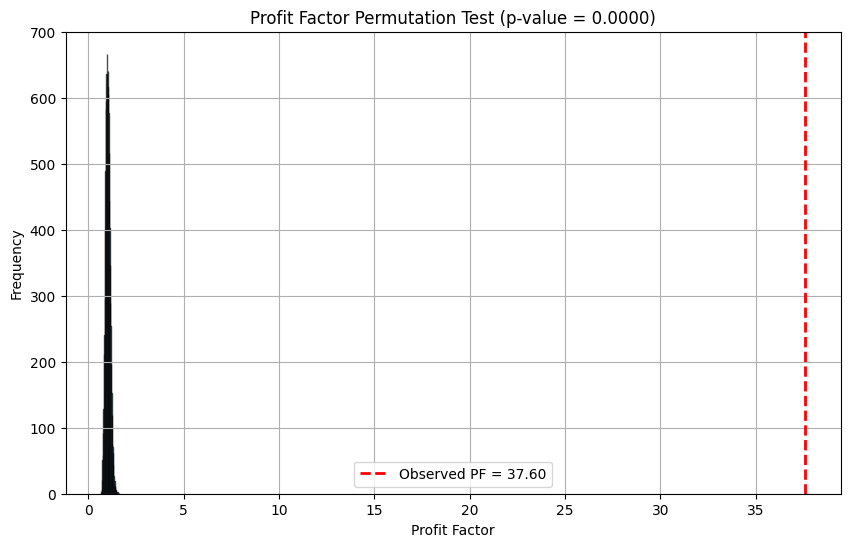


=== Profit Factor Permutation Test ===
Observed Profit Factor: 37.6034
Mean Permutation Profit Factor: 1.0079
P-value: 0.0000
Result: The observed profit factor is statistically significant (p < 0.05)


In [44]:
# Run the walk-forward analysis
oos_results, profit_factor_pvalue = run_walkforward_analysis(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    use_trailing_stop=True,
    exit_bars=5
)